In [165]:
from dataclasses import dataclass
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt

In [166]:
@dataclass
class Data():
    pass

In [167]:
def create_uniform_nodes(N_intervals):
    x_nodes = jnp.linspace(0.0, 1.0, N_intervals+1)
    return x_nodes

In [168]:
def mesh_points(gauss_point: jnp.ndarray, index: int):
    N_cell = gauss_point.shape[0] - 1     # N centres -> N cellules
    x_center = create_uniform_nodes(N_cell)
    dx = 1.0 / N_cell                  # taille d'une cellule uniforme
    xL = x_center[1:] - 0.5 * dx
    xR = x_center[:-1] + 0.5 * dx
    return xL, xR

In [169]:
x_gauss = jnp.linspace(0, 1, 11)
N_cell = len(x_gauss) - 1
print("Gauss points:", x_gauss)
xL, xR = mesh_points(x_gauss, 1)
print("Left mesh points:", xL)
print("Right mesh points:", xR)

Gauss points: [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.        ]
Left mesh points: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
Right mesh points: [0.05       0.15       0.25       0.35000002 0.45000002 0.55
 0.65000004 0.75       0.85       0.95000005]


In [170]:
mesh_points_result = mesh_points(x_gauss, jnp.arange(1, N_cell))
print("Left mesh points:", mesh_points_result[0])
print("Right mesh points:", mesh_points_result[1])

Left mesh points: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
Right mesh points: [0.05       0.15       0.25       0.35000002 0.45000002 0.55
 0.65000004 0.75       0.85       0.95000005]


In [ ]:
def phi(x, x_nodes, i):
    
    N_nodes = x_nodes.size
    x_i = x_nodes[i]

    # Making sure the neighbors indices exist (no out-of-bounds)
    i_left = jnp.maximum(0, i-1)
    i_right = jnp.minimum(N_nodes-1, i+1)
    x_left = x_nodes[i_left]
    x_right = x_nodes[i_right]

    #Test the existence of left / right neighbors
    has_left = i > 0
    has_right = i < (N_nodes - 1)

    # left term: compute denominator safely (1.0 when has_left is False) and mask the result
    denom_left = jnp.where(has_left, (x_i - x_left), 1.0)
    left_term = jnp.where(
        has_left & (x >= x_left) & (x <= x_i),
        (x - x_left) / denom_left,
        0.0
    )

    # right term: compute denominator safely and mask the result
    denom_right = jnp.where(has_right, (x_right - x_i), 1.0)
    right_term = jnp.where(
        has_right & (x > x_i) & (x <= x_right),
        (x_right - x) / denom_right,
        0.0
    )

    return left_term + right_term

# vectorisation sur i
vmap_phi = jax.vmap(phi, in_axes=(None, None, 0))

In [202]:
N = 5
x_nodes = jnp.linspace(0, 1, N)
x = 0.4

values = vmap_phi(x, x_nodes, jnp.arange(N))
print(values)

[0.         0.39999998 0.6        0.         0.        ]


x_nodes: [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.        ]


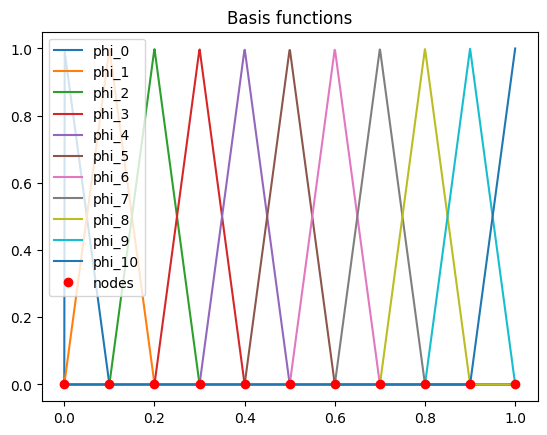

In [203]:
x=jnp.linspace(0, 1, 1000)
x_nodes = jnp.linspace(0, 1, 11)
print("x_nodes:", x_nodes)
index = jnp.arange(0, x_nodes.size)
phi_values = vmap_phi(x, x_nodes, index)
plt.plot(x, phi_values.T,label=[f"phi_{i}" for i in range(x_nodes.size)])
plt.plot(x_nodes, jnp.zeros_like(x_nodes), 'ro', label="nodes")
plt.title("Basis functions")
plt.legend()
plt.show()

In [204]:
def Mass_Matrix(x_nodes, n_quad=500):
    N = x_nodes.size

    # Quadrature (trapèze)
    xq = jnp.linspace(0, 1, n_quad)
    dxq = xq[1] - xq[0]
    w = jnp.ones(n_quad) * dxq
    w = w.at[0].set(dxq/2)
    w = w.at[-1].set(dxq/2)

    # phi_vals: construire un tableau (n_quad, N) où chaque ligne correspond
    # à l'évaluation de toutes les fonctions de base en un point quadrature x_k
    phi_vals = jax.vmap(lambda x: vmap_phi(x, x_nodes, jnp.arange(N)))(xq)  # (n_quad, N)
    

    # Mass matrix: M_ij = sum_k w_k * phi_i(x_k) * phi_j(x_k)
    M = phi_vals.T @ (phi_vals * w[:, None])
    return M

M = Mass_Matrix(x_nodes)
print(M.shape)
print("Mass Matrix:\n", M)

(11, 11)
Mass Matrix:
 [[0.03233803 0.01666177 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.01666177 0.06667283 0.01666499 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.01666499 0.06666721 0.01666741 0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.01666741 0.06666318 0.01666901 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.01666901 0.06666077 0.01666982
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.01666982 0.06665997
  0.01666982 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.01666982
  0.06666076 0.01666901 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.01666901 0.06666315 0.01666741 0.         0.        ]
 [0.     

In [205]:
# Résidual R(U) = - ∫ F(u) dphi_i/dx + [F(u).phi_i]_{x_{i-1/2}}^{x_{i+1/2}} dans le cas ou F=0
def Residual(u_fun, x_nodes, F_func, n_quad=500):
    N = x_nodes.size

    xq = jnp.linspace(0, 1, n_quad)
    dxq = xq[1] - xq[0]
    w = jnp.ones(n_quad) * dxq
    w = w.at[0].set(dxq/2)
    w = w.at[-1].set(dxq/2)

    phi_vals = vmap_phi(xq, x_nodes, jnp.arange(N))             # (n_quad,N)
    dphi_vals = jax.vmap(lambda x: jax.vmap(lambda i: jax.grad(lambda s: phi(s,x_nodes,i))(x))(jnp.arange(N)))(xq)

    u_vals = u_fun(xq)             # (n_quad, dim)
    F_vals = F_func(u_vals)        # (n_quad, dim)

    # R_i = - ∫ F(u) dphi_i/dx
    R = - dphi_vals.T @ (F_vals * w[:,None])
    return R

R= Residual(lambda x: jnp.sin(2*jnp.pi*x), x_nodes, lambda u: u)
print(R)

[[ 0.0000000e+00  1.2364123e-02  2.4726300e-02 ... -2.4726214e-02
  -1.2363760e-02  1.7169197e-07]
 [ 0.0000000e+00  1.2616458e-04  2.5230891e-04 ... -2.5230867e-04
  -1.2616161e-04  1.7519604e-09]
 [ 0.0000000e+00 -9.3132257e-10  0.0000000e+00 ...  0.0000000e+00
   1.8626451e-09  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.2615509e-04 -2.5230367e-04 ...  2.5230180e-04
   1.2613973e-04 -1.7519213e-09]
 [ 0.0000000e+00 -1.2490297e-02 -2.4978612e-02 ...  2.4978526e-02
   1.2489931e-02 -1.7344405e-07]]


In [206]:
# Solving \dot{U} = M^{-1} R(U)
def SemiDiscreteUpdate(u_fun, x_nodes, dt, F_func):
    M = Mass_Matrix(x_nodes)
    R = Residual(u_fun, x_nodes, F_func)
    Minv = jnp.linalg.inv(M)

    dU = Minv @ R  # (N_nodes, dim)
    return dU

In [207]:
def F_zero(u):
    return jnp.zeros_like(u)

def u0(x):
    return jnp.sin(jnp.pi*x)

x_nodes = jnp.linspace(0,1,10)

print(SemiDiscreteUpdate(u0, x_nodes, dt=0.01, F_func=F_zero))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [195]:
def Flux_Function(u,index):
    uL = u[index]
    uR = u[index + 1]
    phi_L= phi

In [196]:
def volume_func(u,j,dt):
    mesh_points = create_uniform_nodes(100)
    u_n = u(mesh_points)
    # phi evaluated at mesh points 
    scalar_phi = lambda x: phi(x, x_nodes, j)
    phi_of_x = scalar_phi(mesh_points)
    # compute d/dx phi at each mesh point
    dphi_of_x_dx = jax.vmap(jax.grad(scalar_phi))(mesh_points)

    #Flux = Flux_Function(u_n,j)
    Flux=0.
    return jnp.sum(u_n * phi_of_x - dt*Flux * dphi_of_x_dx)

vmap_volume_func = jax.vmap(volume_func, in_axes=(None, 0, None))


In [197]:
#fonction erreur
def error_L2(u_pred: jnp.ndarray, u_true: jnp.ndarray):
    return jnp.sqrt(jnp.sum((u_pred - u_true)**2) / u_true.shape[0])


In [198]:
f = lambda x: jnp.sin(2 * jnp.pi * x)*jnp.exp(-5 * x)

N = 200
index = jnp.arange(N)
print("index:", index)
dx = 1.0 / N

x_centers = (index) * dx       # centres réels des volumes
x_nodes   = jnp.linspace(0, 1, N+1)  # nœuds FEM

u_volume = vmap_volume_func(f, index, 0.01)
print("u_volume shape:", u_volume.shape)
print(u_volume[0:5])
print("u_volume shape:", u_volume.shape)


index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
u_volume shape: (200,)
[0.         0.         0.05972819 0.         0.1134062 ]
u_volume shape: (200,)


L2 error: 0.123411134


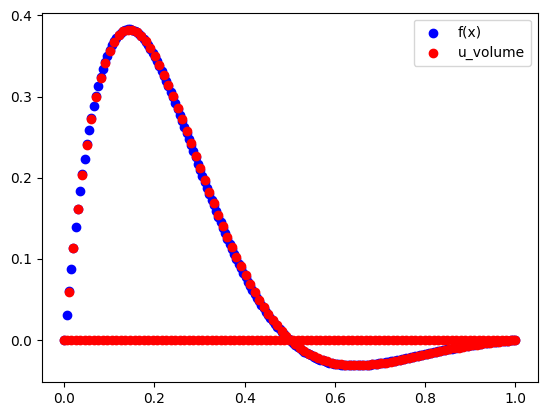

In [199]:
# Visualisation
x_test = jnp.linspace(0, 1, N)
print("L2 error:", error_L2(u_volume, f(x_test)))
plt.scatter(x_test, f(x_test), color='blue', label='f(x)')
plt.scatter(x_test, u_volume, color='red', label='u_volume')
plt.legend()
